In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scienceplots
import seaborn as sns
import matplotlib.animation as animation
from scipy.fft import fft, rfft, fftfreq, rfftfreq
from scipy import signal
from scipy.interpolate import interp1d

def get_pos(N, N_e=8):

    pos     = {}
    node    = N_e

    for y in range(N):
        for x in range(N):

            pos[node]   = (x,y)
            node        += 1

    pos[0] = (-1,-1)
    if N % 2 != 0:
        pos[1] = (int(N/2),-1)
    else:
        pos[1] = (int(N/2)-1,-1)
    pos[2] = (N,-1)
    if N % 2 != 0:
        pos[3] = (-1,int(N/2))
    else:
        pos[3] = (-1,int(N/2)-1)
    pos[4] = (-1,N)
    pos[5] = (N,int(N/2))
    pos[6] = (int(N/2),N)
    pos[7] = (N,N)

    return pos

def min_max(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

N_voltages      = 10000
step_size       = 1e-8
time_steps      = np.cumsum(np.repeat(step_size, N_voltages))
sample_rate     = (N_voltages-1)/np.max(time_steps)
amplitude       = 0.2
time_steps      = time_steps[1:]
time_start      = 4000
time_steps      = time_steps[time_start:]
blue_color      = '#4477AA'
red_color       = '#EE6677'

cmeter      = 1/2.54
single_col  = 8.6

In [221]:
def load_periodic_data(N_NP, path="../../../data/periodic/", frequencies=[1e5,2e5,3e5,4e5,5e5]):

    data = {}

    for frequency in frequencies:

        dfs     = []
        n_stat  = 0
        
        for i in range(0,10):
            for j in range(5):

                df_tmp  = pd.read_csv(path+f"f={(np.round(frequency))}_A={amplitude}Nx={N_NP}_Ny={N_NP}_Nz=1_Ne=2_{i}_{j}.csv")
                dfs.append(df_tmp.iloc[time_start:,:].reset_index(drop=True))
                n_stat  += 1

        df              = sum(dfs)/len(dfs)
        test            = pd.DataFrame(np.std(np.stack(dfs), axis=0), columns=df.columns)
        df['Error']     = test['Current']
        df              = df.drop(columns=['Eq_Jumps'])
        df['Error']     = df['Error']/np.sqrt(n_stat)
        df.loc[(df['Error']/df['Current']).abs() > 0.1,'Current'] = 0.0
        data[frequency] = df

    return data

# Main

In [222]:
data        = {N : load_periodic_data(N) for N in [3,5,7,9]}
data_dis    = {N : load_periodic_data(N, path="../../../data/periodic/dis_") for N in [3,5,7,9]}
# data_disR   = {N : load_periodic_data(N, path="../../../data/periodic/disR_") for N in [7]}

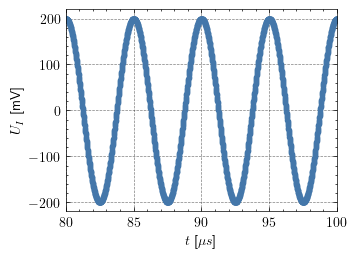

In [223]:
frequency   = 2e5
N_NP        = 7

with plt.style.context(['science', 'bright', 'grid']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.plot(time_steps*10**6, data[N_NP][frequency]['E0']*1000, '.-', color=blue_color, markevery=1)
    # ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=red_color, alpha=.6)
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('$U_I$ [mV]')
    ax1.set_xlim(80,100)
    # ax1.legend(loc='upper left')
    # ax1.set_ylim(-1,1)

    fig.savefig(f"plots/input_signal/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_input_signal.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/input_signal/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_input_signal.pdf", bbox_inches='tight', transparent=False)

plt.show()

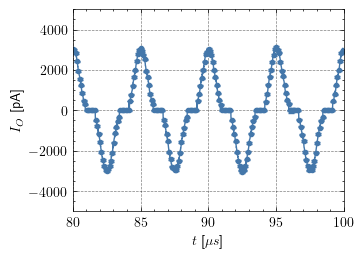

In [245]:
frequency   = 2e5
N_NP        = 7
data_type   = 1

with plt.style.context(['science', 'bright', 'grid']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()

    if data_type == 0:
        ax1.errorbar(time_steps*10**6, data[N_NP][frequency]['Current'], data[N_NP][frequency]['Error'], color=blue_color, markevery=10, marker='.', errorevery=10, capsize=2)
    elif data_type == 1:
        ax1.errorbar(time_steps*10**6, data_dis[N_NP][frequency]['Current'], data[N_NP][frequency]['Error'], color=blue_color, markevery=10, marker='.', errorevery=10, capsize=2)
    elif data_type == 2:
        ax1.errorbar(time_steps*10**6, data_disR[N_NP][frequency]['Current'], data[N_NP][frequency]['Error'], color=blue_color, markevery=10, marker='.', errorevery=10, capsize=2)
    
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('$I_O$ [pA]')
    ax1.set_xlim(80,100)
    ax1.set_ylim(-5000,5000)
    # ax1.legend(loc='upper left')
    # ax1.set_ylim(-1,1)

    if data_type == 0:
        fig.savefig(f"plots/output_signal/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_output_signal.svg", bbox_inches='tight', transparent=True)
        fig.savefig(f"plots/output_signal/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_output_signal.pdf", bbox_inches='tight', transparent=False)
    
    elif data_type == 1:
        fig.savefig(f"plots/output_signal/"+f"dis_f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_output_signal.svg", bbox_inches='tight', transparent=True)
        fig.savefig(f"plots/output_signal/"+f"dis_f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_output_signal.pdf", bbox_inches='tight', transparent=False)
    
    elif data_type == 2:
        fig.savefig(f"plots/output_signal/"+f"disR_f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_output_signal.svg", bbox_inches='tight', transparent=True)
        fig.savefig(f"plots/output_signal/"+f"disR_f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_output_signal.pdf", bbox_inches='tight', transparent=False)
    
plt.show()

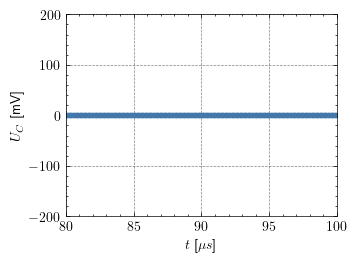

In [225]:
frequency   = 1e5
N_NP        = 7

with plt.style.context(['science', 'bright', 'grid']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.errorbar(time_steps*10**6, np.repeat(0,len(time_steps)), color=blue_color, marker='.', markevery=10)
    # ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=blue_color, alpha=0.8)
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('$U_C$ [mV]')
    ax1.set_xlim(80,100)
    ax1.set_ylim(-200,200)
    # ax1.legend(loc='upper left')
    # ax1.set_ylim(-1,1)

    fig.savefig(f"plots/input_signal/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_control_signal.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/input_signal/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_control_signal.pdf", bbox_inches='tight', transparent=False)
plt.show()

## Frequency

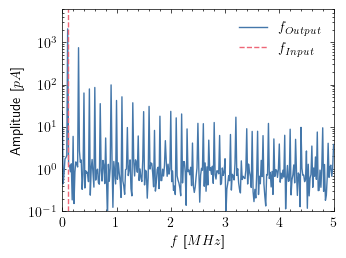

In [232]:
frequency   = 1e5
N_NP        = 7
data_type   = 1

if data_type == 0:
    signal      = data[N_NP][frequency]['Current'].values
    
elif data_type == 1:
    signal      = data_dis[N_NP][frequency]['Current'].values
    
elif data_type == 2:
    signal      = data_disR[N_NP][frequency]['Current'].values
     
input_f     = frequency/10**6
yf          = rfft(signal)
xf          = rfftfreq(len(signal)-1, 1 / sample_rate)/10**6
f_spectrum  = 2*np.abs(yf)/len(signal)

with plt.style.context(['science', 'bright']):

    fig = plt.figure()
    ax  = fig.add_subplot()

    ax.plot(xf, f_spectrum, label="$f_{Output}$", lw=1)
    ax.axvline(input_f, color=red_color, ls='--', label="$f_{Input}$")
    # ax.axvline(input_f, color=red_color, ls='--', label="$\omega_{Input}$")
    ax.set_xlabel("$f$ [$MHz$]")
    ax.set_ylim(0.1,6000)
    ax.set_ylabel('Amplitude [$pA$]')
    ax.set_yscale('log')
    ax.set_xlim(0,5*input_f*10)
    ax.legend()
    
    if data_type == 0:
        fig.savefig(f"plots/fft/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_FFT_periodic_signal.svg", bbox_inches='tight', transparent=True)
        fig.savefig(f"plots/fft/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_FFT_periodic_signal.pdf", bbox_inches='tight', transparent=False)
    elif data_type == 1:
        fig.savefig(f"plots/fft/"+f"dis_f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_FFT_periodic_signal.svg", bbox_inches='tight', transparent=True)
        fig.savefig(f"plots/fft/"+f"dis_f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_FFT_periodic_signal.pdf", bbox_inches='tight', transparent=False)
    elif data_type == 2:
        fig.savefig(f"plots/fft/"+f"disR_f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_FFT_periodic_signal.svg", bbox_inches='tight', transparent=True)
        fig.savefig(f"plots/fft/"+f"disR_f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_FFT_periodic_signal.pdf", bbox_inches='tight', transparent=False)
    
plt.show()

In [227]:
def nonlinear_index(df : pd.DataFrame, main_frequency : float, sample_rate : float, time_scale=10**6, number_of_frequencies=10):

    N_values    = len(df)

    # Fourier Spectrum
    arr     = df.loc[:,'Current'].values
    xf      = rfftfreq(N_values-1, 1 / sample_rate)/time_scale
    yf      = 2*np.abs(rfft(arr))/len(signal)
    df_f    = pd.DataFrame([xf, yf]).T

    df_f    = df_f[df_f[0] >= (main_frequency/time_scale)]
    df_f    = df_f.loc[df_f.loc[:,1].nlargest(number_of_frequencies).index].reset_index(drop=True)
    a       = df_f.iloc[1:,1].sum()
    b       = df_f.iloc[0,1]
    n_idx   = a/b

    return n_idx

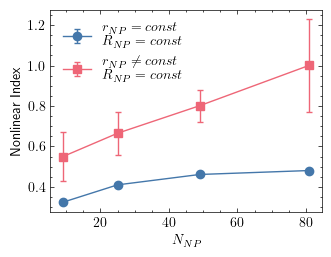

In [238]:
number_of_freqs = 100

with plt.style.context(['science', 'bright']):

    fig = plt.figure()
    ax  = fig.add_subplot()

    means   = []
    stds    = []
    for N_NP in [3,5,7,9]:
        vals = []
        for frequency in [1e5,2e5,3e5,4e5,5e5]:
            vals.append(nonlinear_index(data[N_NP][frequency], frequency, sample_rate, number_of_frequencies=number_of_freqs))
        means.append(np.mean(vals))
        stds.append(np.std(vals)/np.sqrt(5))

    ax.errorbar(np.array([3,5,7,9])**2, means, stds, marker='o', label='$r_{NP} = const$\n$R_{NP} = const$', capsize=2.5)

    means   = []
    stds    = []
    for N_NP in [3,5,7,9]:
        vals = []
        for frequency in [1e5,2e5,3e5,4e5,5e5]:
            vals.append(nonlinear_index(data_dis[N_NP][frequency], frequency, sample_rate, number_of_frequencies=number_of_freqs))
        means.append(np.mean(vals))
        stds.append(np.std(vals)/np.sqrt(5))
    
    ax.errorbar(np.array([3,5,7,9])**2, means, stds, marker='s', label='$r_{NP} \\neq const$\n$R_{NP} = const$', capsize=2.5)

    # means   = []
    # stds    = []
    # for N_NP in [7]:
    #     vals = []
    #     for frequency in [1e5,2e5,3e5,4e5,5e5]:
    #         vals.append(nonlinear_index(data_disR[N_NP][frequency], frequency, sample_rate, number_of_frequencies=number_of_freqs))
    #     means.append(np.mean(vals))
    #     stds.append(np.std(vals)/np.sqrt(5))
    
    # ax.errorbar(np.array([7])**2, means, stds, marker='P', label='$r_{NP} = const$\n$R_{NP} \\neq const$', capsize=2.5)

    ax.legend(loc='upper left')
    ax.set_xlabel('$N_{NP}$')
    ax.set_ylabel('Nonlinear Index')
    fig.savefig(f"plots/metrics/output_nonlinear_index_vs_system_size.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/metrics/output_nonlinear_index_vs_system_size.pdf", bbox_inches='tight', transparent=False)
    
plt.show()

In [88]:
N_NP        = 7
ccorr_list  = []

for key, df in data_disR[N_NP].items():
    
    test_x  = df['E0'].values
    test_y  = df['Current'].values
    lags    = np.arange(0, len(test_x))
    x       = test_x - np.mean(test_x)
    y       = test_y - np.mean(test_y)
    ccorr   = [(np.correlate(test_x, np.roll(test_y, -lag)) / (np.linalg.norm(test_x) * np.linalg.norm(test_y)))[0] for lag in lags]
    
    ccorr_list.append(ccorr)

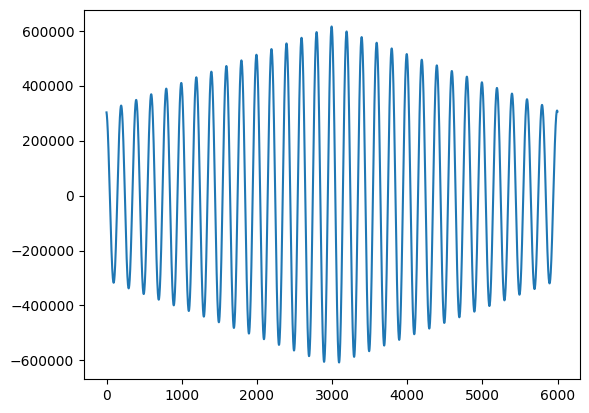

In [89]:
plt.plot(lags, np.correlate(test_x, test_y, mode='same'))
plt.show()

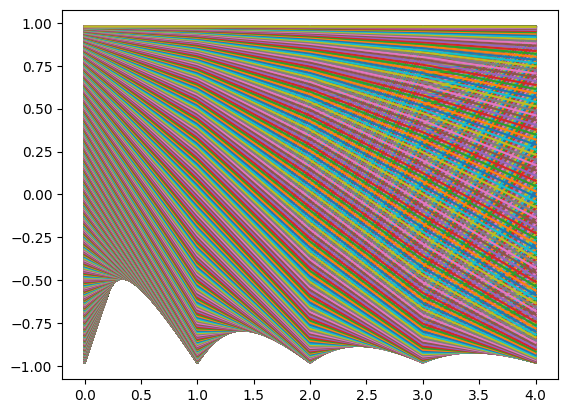

In [80]:
plt.plot(ccorr_list)
plt.show()

## Nonlinear Index at Output

In [12]:
n_indices   = []

for frequency in data:

    signal      = data[frequency]['Current'].values
    input_f     = frequency/10**6

    yf          = rfft(signal)
    xf          = rfftfreq(N_voltages-1, 1 / sample_rate)/10**6
    f_spectrum  = 2*np.abs(yf)/len(signal)

    f_df    = pd.DataFrame([xf, f_spectrum]).T
    # f_df    = f_df.loc[f_df[1] > 10].reset_index(drop=True)
    f_df    = f_df.loc[f_df.loc[:,1].nlargest(n_freq).index].reset_index(drop=True)
    a       = f_df.iloc[1:,1].sum()
    b       = f_df.iloc[0,1]
    n_idx   = a/b

    n_indices.append(n_idx)

n_indices

[0.22091541716871516, 0.21961527114676357]

## State

In [13]:
data_states = {}

for frequency in data:

    dfs         = []
    n_stat      = 0
    ele_charge  = 1.60217663e-19

    for i in range(0,10):
        for j in range(5):

            df_tmp          = pd.read_csv("data/periodic/"+f"f={(np.round(frequency))}_A={amplitude}"+f"mean_state_Nx={N_NP}_Ny={N_NP}_Nz=1_Ne=2_{i}_{j}.csv")
            dfs.append(df_tmp)
            n_stat += 1

    df_states               = sum(dfs)/len(dfs)
    data_states[frequency]  = df_states

In [14]:
data_pots = {key : 1000*pd.DataFrame(np.dot(inv_cap, data_states[key].T)).T for key in data_states}

NameError: name 'inv_cap' is not defined

In [129]:
data_pots[1e5]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.610103,5.942909,-3.885694,-4.835411,3.262444,2.637072,-6.869309,3.769500,-0.911361,-3.732696,...,-1.981246,3.867084,1.109393,3.063830,4.220116,5.504757,2.751861,-3.310551,1.384945,2.498454
1,-2.601758,4.771386,-3.875833,-3.097092,1.564018,-0.133747,-1.180544,3.270626,1.283880,-2.716910,...,-0.124721,2.873926,-0.112961,0.653518,5.857788,7.944383,0.607461,-1.954908,-3.782106,2.044495
2,-1.654343,2.419218,-2.839226,-3.695227,2.725047,2.048534,-2.735029,2.926319,-0.342903,0.457587,...,-1.187203,3.768886,-0.012626,-1.358116,3.221870,4.688606,-0.554881,0.446793,-2.564152,-0.216403
3,0.103980,0.750228,-0.362608,-0.830819,2.171020,1.712384,-0.686857,1.598246,-0.384014,-0.498497,...,-0.691827,4.755976,1.984511,-2.156957,3.109564,3.683494,0.002512,2.788606,-0.214219,1.748399
4,-2.402926,-1.226767,1.792504,0.227002,1.699357,2.050688,-0.598858,1.530016,-1.729551,-0.390804,...,-0.554700,4.143860,2.018534,-0.159510,2.447787,3.990403,0.166082,0.378587,0.831849,1.847256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.186257,-0.128277,-0.098328,0.038672,-0.345845,-0.230119,0.019980,-0.083964,-0.061774,-0.076609,...,-0.000776,-0.139960,0.169024,0.219798,0.114923,0.242943,-0.119093,0.098204,-0.035383,0.088714
4995,0.192343,-0.125507,-0.098127,0.038580,-0.341270,-0.228763,0.021889,-0.080321,-0.064425,-0.077180,...,-0.002341,-0.137480,0.167925,0.221819,0.113760,0.235678,-0.115494,0.096097,-0.034136,0.078235
4996,0.193736,-0.117663,-0.090500,0.037797,-0.336829,-0.228080,0.022354,-0.079734,-0.060372,-0.074944,...,-0.003844,-0.136542,0.170064,0.217506,0.105537,0.236497,-0.113600,0.099768,-0.036748,0.071632
4997,0.191210,-0.116281,-0.091921,0.037400,-0.335580,-0.230802,0.013630,-0.077003,-0.060394,-0.072507,...,-0.001849,-0.135310,0.166626,0.217413,0.108833,0.236982,-0.107602,0.104487,-0.038242,0.071740


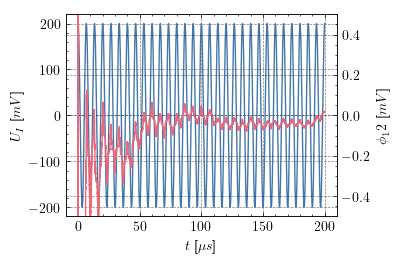

In [407]:
start       = 0
stop        = 20000
np_idx      = 12
frequency   = 1.5e5

with plt.style.context(['science', 'bright','grid']):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time_steps[start:stop]*10**6, data[frequency].loc[start:stop,'E0']*1000, c=blue_color)

    ax2 = ax.twinx()
    ax2.plot(time_steps[start:stop]*10**6, data_pots[frequency].iloc[start:stop,np_idx], c=red_color)

    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("$U_I$ [$mV$]")
    # ax.set_xlim(45,50)
    # ax.set_ylim(-200,200)
    ax2.set_ylabel(f"$\phi_{np_idx}$ [$mV$]")
    ax2.set_ylim(-.5,.5)

plt.show()

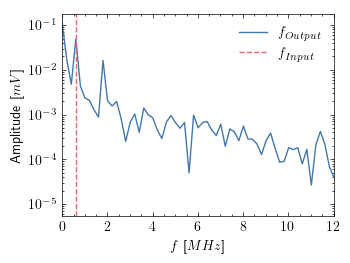

In [445]:
start       = 4500
stop        = 5000
N_values    = stop-start
frequencyF  = 6
frequency   = frequencyF*10**5
# signal      = np.int16((data[frequency]['Current'].values / data[frequency]['Current'].values.max()) * 32767)
signal      = data_pots[frequency].iloc[start:stop,np_idx].values
signal      = signal #- np.mean(signal)
input_f     = frequency/10**6

yf          = rfft(signal)
xf          = rfftfreq(N_values-1, 1 / sample_rate)/10**6
f_spectrum  = 2*np.abs(yf)/len(signal)

with plt.style.context(['science', 'bright']):

    fig = plt.figure()
    ax  = fig.add_subplot()

    ax.plot(xf, f_spectrum, label="$f_{Output}$", lw=1)
    ax.axvline(input_f, color=red_color, ls='--', label="$f_{Input}$")
    # ax.axvline(input_f, color=red_color, ls='--', label="$\omega_{Input}$")
    ax.set_xlabel("$f$ [$MHz$]")
    # ax.set_ylim(10,6000)
    ax.set_ylabel('Amplitude [$mV$]')
    ax.set_yscale('log')
    ax.set_xlim(0,2*frequencyF)
    ax.legend()
    
plt.show()

In [448]:
n_freq      = 6
np_idx      = 12
start       = 4500
stop        = 5000
N_values    = stop-start


n_indices   = []

for frequency in data:

    n_per_np = []

    for np_idx in range(25):

        signal      = data_pots[frequency].iloc[start:stop,np_idx].values
        input_f     = frequency/10**6

        yf          = rfft(signal)
        xf          = rfftfreq(N_values-1, 1 / sample_rate)/10**6
        f_spectrum  = 2*np.abs(yf)/len(signal)

        f_df    = pd.DataFrame([xf, f_spectrum]).T
        f_df    = f_df[f_df[0]>=input_f]
        f_df    = f_df.loc[f_df.loc[:,1].nlargest(n_freq).index].reset_index(drop=True)
        a       = f_df.iloc[1:,1].sum()
        b       = f_df.iloc[0,1]
        n_idx   = a/b

        n_per_np.append(n_idx)

    n_indices.append(np.mean(n_per_np))

n_indices

[2.0311784864181943,
 0.791119315715735,
 0.6670945795232179,
 1.6329226886071297,
 0.666449502765351,
 1.528231336817144,
 0.649428898645821,
 1.517553031213802,
 0.6097841816136289,
 1.4328429030552206,
 0.596957190179923]

## NP Phase Space

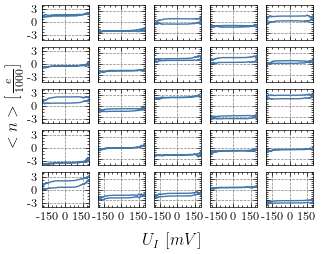

In [296]:
ele_charge = 1.60217663e-19
plot_order = [20,21,22,23,24,15,16,17,18,19,10,11,12,13,14,5,6,7,8,9,0,1,2,3,4]

with plt.style.context(['science', 'bright','grid']):

    fig = plt.figure()

    for n,i in enumerate(plot_order):
        
        ax  = fig.add_subplot(5,5,n+1)
        ax.plot(df.loc[4000:5000,'E0']*1000, 1000*df_states.iloc[4000:5000,i])
        ax.set_xlim(-200,200)
        ax.set_ylim(-4,4)
        
        ax.set_xticklabels('')
        ax.set_yticklabels('')

        if n > 19:
            ax.set_xticks([-150,0,150])
            ax.set_xticklabels([-150,0,150], fontsize='small')

        if n % 5 == 0:
            ax.set_yticks([-3,0,3])
            ax.set_yticklabels([-3,0,3], fontsize='small')

    fig.supxlabel('$U_I$ [$mV$]', y=-0.05)
    fig.supylabel('$<n>$ [$\\frac{e}{1000}$]')

    fig.savefig(f"plots/states/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_n_vs_U_grid.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/states/"+f"f={(np.round(frequency))}_A={amplitude}"+f"N_{N_NP}_n_vs_U_grid.pdf", bbox_inches='tight', transparent=False)

    plt.show()

## Disorder

In [3]:
N_voltages  = 10000
step_size   = 1e-8
time_steps  = np.cumsum(np.repeat(step_size, N_voltages))
sample_rate = (N_voltages-1)/np.max(time_steps)
amplitude   = 0.2
time_steps  = time_steps[1:]
N_NP        = 7

In [29]:
data    = {}
N_NP    = 7

for frequency in [1e5,2e5,3e5,4e5,5e5]:

    dfs     = []
    n_stat  = 0

    for i in range(0,10):
        for j in range(5):

            df_tmp      = pd.read_csv(f"../../../data/periodic/f={frequency}_A={amplitude}Nx={N_NP}_Ny={N_NP}_Nz=1_Ne=2_{i}_{j}.csv")
            dfs.append(df_tmp)
            n_stat      += 1

    df              = sum(dfs)/len(dfs)
    test            = pd.DataFrame(np.std(np.stack(dfs), axis=0), columns=df.columns)
    df['Error']     = test['Current']
    df              = df.drop(columns=['Eq_Jumps'])
    df['Error']     = df['Error']/np.sqrt(n_stat)
    data[frequency] = df

In [53]:
pos = [(-1,-1),(5,5),(0,0),(1,0),(2,0),(3,0),(4,0),
       (0,1),(1,1),(2,1),(3,1),(4,1),
       (0,2),(1,2),(2,2),(3,2),(4,2),
       (0,3),(1,3),(2,3),(3,3),(4,3),
       (0,4),(1,4),(2,4),(3,4),(4,4)]
pos = {i : pos[i] for i in range(0,27)}

In [54]:
N_NP    = 5
G       = nx.DiGraph()
G.add_nodes_from([i for i in range(N_NP*N_NP+2)])
G.add_edges_from([eval(i) for i in pd.read_csv(f"../../../data/periodic/dis_f={1e5}_A={amplitude}net_currents_Nx={N_NP}_Ny={N_NP}_Nz=1_Ne=2_0_0.csv").columns])
node_color      = np.repeat(blue_color, N_NP*N_NP+2)
node_color[0:2] = None
node_labels     = {i:'' for i in range(N_NP*N_NP+2)}
node_labels[0]  = '$I$'
node_labels[1]  = '$O$'

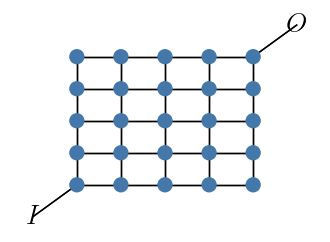

In [60]:
with plt.style.context(['science','bright']):
    
    fig         = plt.figure()
    ax1         = fig.add_subplot()
    sizes       = np.repeat(0,N_NP*N_NP+2)
    sizes[2:]   = np.repeat(100,N_NP*N_NP)
    node_colors = np.repeat(blue_color, N_NP*N_NP+2)

    nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax1, node_color=node_colors, arrows=False, labels=node_labels, font_size=20)
    plt.tight_layout()
    plt.axis('off')
    fig.savefig(f"plots/graphs/default_graph_{N_NP}.svg", bbox_inches='tight', transparent=True)
    plt.show()

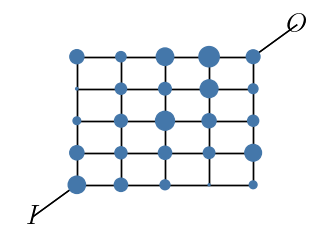

In [81]:
with plt.style.context(['science','bright']):
    
    fig         = plt.figure()
    ax1         = fig.add_subplot()
    sizes       = np.repeat(0,N_NP*N_NP+2)
    sizes[2:]   = np.abs(np.random.normal(100,50,N_NP*N_NP))
    node_colors = np.repeat(blue_color, N_NP*N_NP+2)

    nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax1, node_color=node_colors, arrows=False, labels=node_labels, font_size=20)
    plt.tight_layout()
    plt.axis('off')
    fig.savefig(f"plots/graphs/default_dis_graph_{N_NP}.svg", bbox_inches='tight', transparent=True)
    plt.show()

In [62]:
data_dis    = {}
N_NP        = 5

for frequency in [1e5,2e5,3e5,4e5,5e5]:

    dfs     = []
    n_stat  = 0

    for i in range(0,10):
        for j in range(5):

            df_tmp      = pd.read_csv(f"../../../data/periodic/dis_f={frequency}_A={amplitude}Nx={N_NP}_Ny={N_NP}_Nz=1_Ne=2_{i}_{j}.csv")
            dfs.append(df_tmp)
            n_stat      += 1

    df                  = sum(dfs)/len(dfs)
    test                = pd.DataFrame(np.std(np.stack(dfs), axis=0), columns=df.columns)
    df['Error']         = test['Current']
    df                  = df.drop(columns=['Eq_Jumps'])
    df['Error']         = df['Error']/np.sqrt(n_stat)
    data_dis[frequency] = df

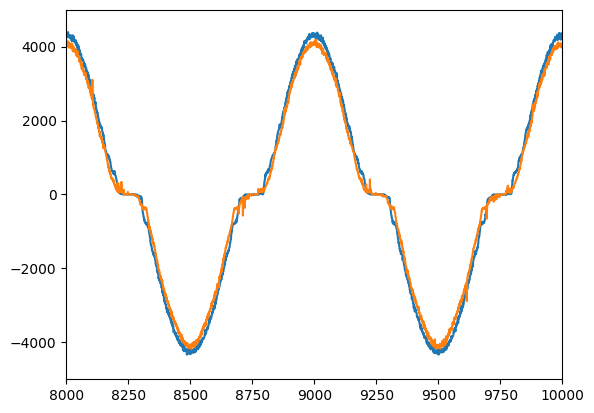

In [63]:
plt.plot(data[1e5]['Current'])
plt.plot(data_dis[1e5]['Current'])
plt.xlim(8000,10000)
plt.ylim(-5000,5000)
plt.show()

In [216]:
df_tmp      = pd.DataFrame()
df_tmp['U'] = (df.loc[1000:,'E0']*1000).values
df_tmp['n'] = (df_states.iloc[1000:,24]).values
df_tmp['t'] = (time_steps*10**6)[1000:]
df_tmp

,U,n,t
0,99.994943,0.002753,400.560224
1,99.938055,0.002734,400.960384
2,99.817993,0.002752,401.360544
3,99.634834,0.002807,401.760704
4,99.388693,0.002826,402.160864
...,...,...,...
1494,99.210840,0.000896,998.399360
1495,99.494698,0.000842,998.799520
1496,99.715663,0.000868,999.199680
1497,99.873595,0.000799,999.599840


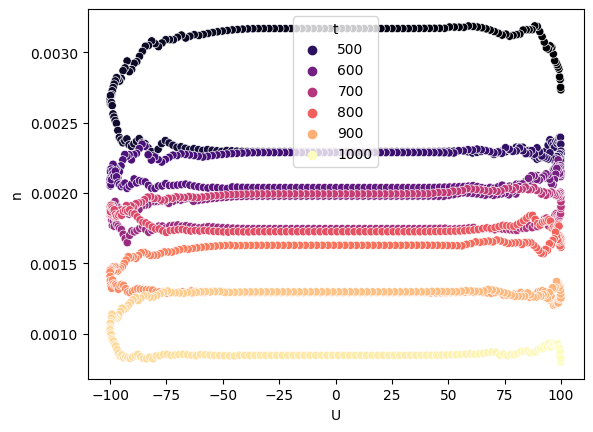

In [217]:
sns.scatterplot(data=df_tmp, x='U', y='n', hue='t', palette='magma')
plt.show()

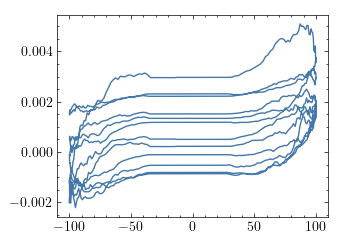

In [196]:
ele_charge  = 0.160217662
cmap        = plt.get_cmap('magma')

with plt.style.context(['science', 'bright']):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(df.loc[1000:,'E0']*1000, df_states.iloc[1000:,0], '-')
    # ax.set_xlim(0,1000)
    ax.set_ylim()

# plt.plot(df_states.iloc[:,10])
plt.show()

## I-O dependency

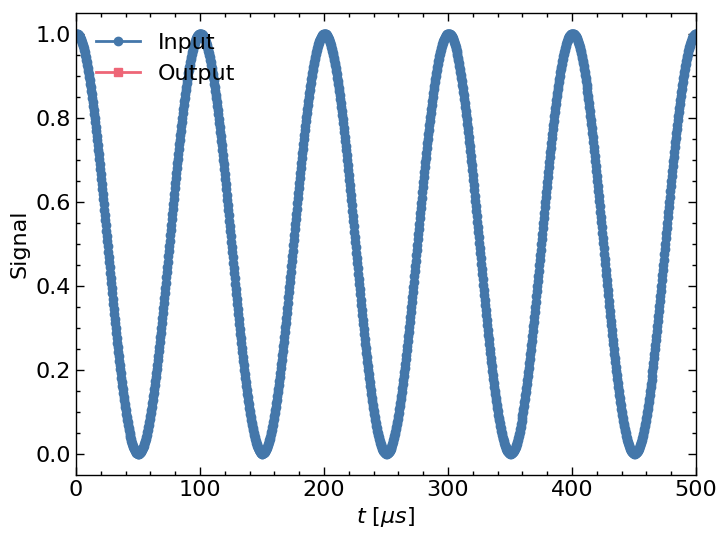

In [79]:
with plt.style.context(['science', 'bright', 'notebook']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.plot(time_steps*10**6, min_max(df['E0']), '-o', color=blue_color, label='Input')
    ax1.plot(time_steps*10**6, min_max(df['Current']), '-s', color=red_color, label='Output')
    # ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=red_color, alpha=.6)
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('Signal')
    ax1.set_xlim(0,500)
    ax1.legend(loc='upper left')
    # ax1.set_ylim(-1,1)

    # fig.savefig(f"plots/"+f_str+"I_O_periodic_signal.svg", bbox_inches='tight', transparent=True)
    # fig.savefig(f"plots/"+f_str+"I_O_periodic_signal.pdf", bbox_inches='tight', transparent=False)
plt.show()

## combined

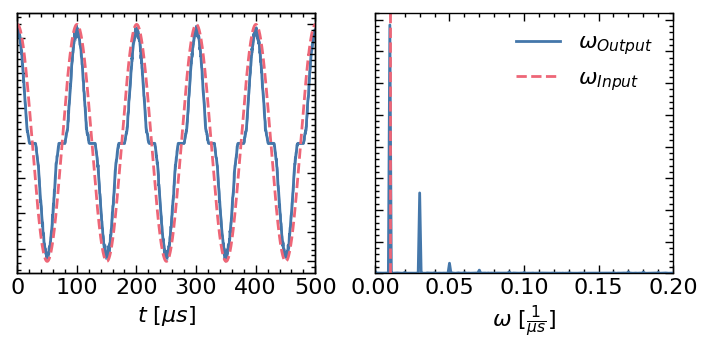

In [11]:
signal  = np.int16((df['Current'].values / df['Current'].values.max()) * 32767)
signal  = df['Current'].values
input_f = freq*(1e5)/10**6

with plt.style.context(['science', 'bright', 'notebook']):

    fig = plt.figure()
    fig.set_figwidth(2.5*single_col*cmeter)
    fig.set_figheight(single_col*cmeter/1)

    ax1 = fig.add_subplot(1,2,1)
    ax2 = ax1.twinx()
    ax1.plot(time_steps*10**6, df['Current'].values, '-', color=blue_color, label='$I$')
    ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=blue_color, alpha=.6)
    ax2.plot(time_steps*10**6, df['E0'].values, '--', color=red_color, label='$U_I$')
    ax1.set_xlabel('$t$ [$\mu s$]')
    # ax1.set_ylabel('Signal')
    ax1.set_xlim(0,500)
    ax1.set_yticklabels("")
    ax2.set_yticklabels("")
    # ax1.legend(loc='lower right')

    yf = rfft(signal)
    xf = rfftfreq(N_voltages-1, 1 / sample_rate)

    ax  = fig.add_subplot(1,2,2)
    ax.plot(xf/10**6, np.abs(yf), label="$\omega_{Output}$")
    ax.axvline(input_f, color=red_color, label="$\omega_{Input}$", ls='--')
    ax.set_xlabel("$\omega$ [$\\frac{1}{\mu s}$]")
    ax.set_ylim(0)
    ax.set_xlim(0,0.2)
    ax.legend()
    ax.set_yticklabels("")
    plt.subplots_adjust(wspace=0.2)

    fig.savefig(f"plots/"+f_str+f"N={N_NP}_1_In_1_Out_time_dep.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/"+f_str+f"N={N_NP}_1_In_1_Out_time_dep.pdf", bbox_inches='tight', transparent=False)

plt.show()

## Animtaion

In [16]:
G   = nx.DiGraph()
G.add_nodes_from([i for i in range(N_NP*N_NP+8)])
G.add_edges_from([eval(i) for i in pd.read_csv(f"data/periodic/"+f_str+f"net_currents_Nx={N_NP}_Ny={N_NP}_Nz=1_Ne=8_0_0.csv").columns])
pos             = get_pos(N_NP)
node_color      = np.repeat(blue_color, N_NP*N_NP+8)
node_color[0:8] = None
node_labels     = {i:'' for i in range(N_NP*N_NP+8)}
node_labels[0]  = '$I$'
node_labels[2]  = '$C$'
node_labels[4]  = '$C$'
node_labels[7]  = '$O$'
node_labels[1]  = '$C$'
node_labels[3]  = '$C$'
node_labels[5]  = '$C$'
node_labels[6]  = '$C$'

In [11]:
n_stat  = 1
states  = pd.read_csv(f"data/periodic/"+f_str+"mean_state_Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")

for i in range(0,10):
    for j in range(5):
        if not((i == 0) and (j == 0)):
            states += pd.read_csv("data/periodic/"+f_str+f"mean_state_Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
            n_stat += 1
            
states = states/n_stat

MovieWriter ffmpeg unavailable; using Pillow instead.


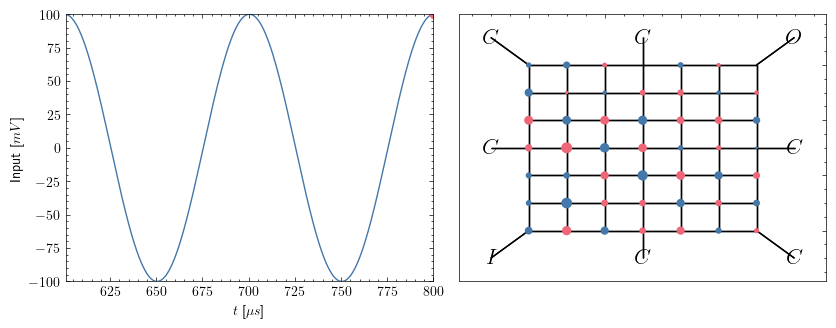

In [12]:
raw_data    = pd.read_csv("data/periodic/"+f_str+"Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
in_vals     = 1000*raw_data['E0'].values
t_vals      = time_steps*10**6

start_ind   = 1500
n_frames    = 500
in_vals     = in_vals[start_ind:start_ind+n_frames]
t_vals      = t_vals[start_ind:start_ind+n_frames]

with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    fig.set_figwidth(2.5*single_col*cmeter)
    fig.set_figheight(single_col*cmeter/1)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    def update(row):

        ax1.clear()
        ax1.plot(t_vals, in_vals)
        ax1.plot(t_vals[row], in_vals[row], 'o')
        ax1.set_xlabel('$t$ [$\mu s$]')
        ax1.set_ylabel('Input [$mV$]')
        ax1.set_xlim(np.round(np.min(t_vals)),np.round(np.max(t_vals)))
        ax1.set_ylim(-100,100)

        ax2.clear()

        sizes       = np.repeat(0,49+8)
        s_vals      = states.iloc[row].values
        sizes[8:]   = 5000*np.abs(s_vals)

        node_colors = np.repeat(blue_color, 49+8)
        node_colors[8:][s_vals < 0] = red_color

        nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax2, node_color=node_colors, arrows=False, labels=node_labels, font_size=16)
        ax.set_title(f'$t = {np.round((10**6)*time_steps[row],2)}$ $\mu s$')
        plt.tight_layout()
        # plt.axis('off')
        
    ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=200, repeat_delay=1000, repeat=True)
    ani.save("plots/gifs/"+f_str+"anim.gif", dpi=200)

plt.show()

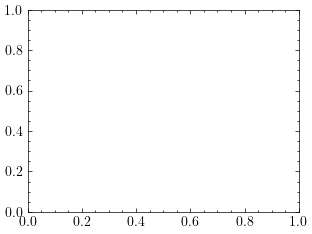

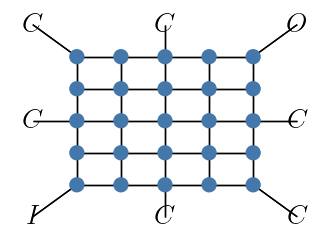

In [17]:
with plt.style.context(['science','bright']):
    
    fig         = plt.figure()
    ax1         = fig.add_subplot()
    sizes       = np.repeat(0,N_NP*N_NP+8)
    sizes[8:]   = np.repeat(100,N_NP*N_NP)
    node_colors = np.repeat(blue_color, N_NP*N_NP+8)

    nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax1, node_color=node_colors, arrows=False, labels=node_labels, font_size=20)
    plt.tight_layout()
    plt.axis('off')
    fig.savefig(f"default_graph_{N_NP}.svg", bbox_inches='tight', transparent=True)
    plt.show()

### Noise

In [19]:
noise_data  = {}
n           = 0

for i in range(0,10):

    for j in range(5):

        df_tmp          = pd.read_csv(f"data/noise/Nx=5_Ny=5_Nz=1_Ne=8_{i}_{j}.csv")
        df_tmp          = df_tmp.drop(columns=['Eq_Jumps', 'Error'])
        noise_data[n]   = df_tmp
        n               += 1

noise_data[0]

,E0,E1,E2,E3,E4,E5,E6,E7,G,Jumps,Current
0,-0.205588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48878.0,-302.380881
1,-0.229423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88948.0,-342.364595
2,-0.250388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133914.0,-362.365709
3,-0.283005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187065.0,-429.830945
4,-0.287909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,241277.0,-507.305568
...,...,...,...,...,...,...,...,...,...,...,...
2494,0.656958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239703128.0,1994.204136
2495,0.648780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239850170.0,2009.209615
2496,0.655751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240000268.0,2096.672231
2497,0.672491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240152825.0,2154.157836


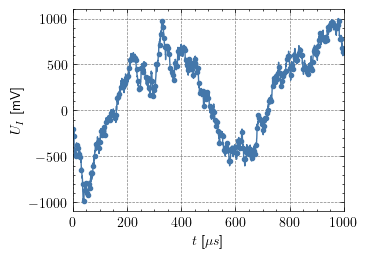

In [42]:
n = 20

with plt.style.context(['science', 'bright', 'grid']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.plot(time_steps*10**6, noise_data[n]['E0']*1000, '.-', color=blue_color, markevery=10)
    # ax1.plot(time_steps*10**6, noise_data[10]['E0'], '.-', color=blue_color, markevery=10)
    # ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=red_color, alpha=.6)
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('$U_I$ [mV]')
    ax1.set_xlim(0,1000)
    # ax1.legend(loc='upper left')
    # ax1.set_ylim(-1,1)

    fig.savefig(f"plots/noise_input_signal_{n}.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/noise_input_signal_{n}.pdf", bbox_inches='tight', transparent=False)

plt.show()

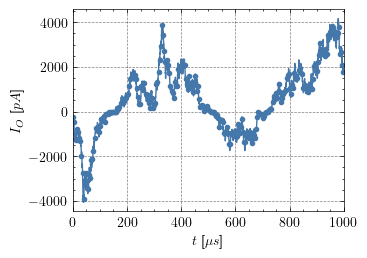

In [45]:
n = 20

with plt.style.context(['science', 'bright', 'grid']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.plot(time_steps*10**6, noise_data[n]['Current'], '.-', color=blue_color, markevery=10)
    # ax1.plot(time_steps*10**6, noise_data[10]['E0'], '.-', color=blue_color, markevery=10)
    # ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=red_color, alpha=.6)
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('$I_O$ [$pA$]')
    ax1.set_xlim(0,1000)
    # ax1.legend(loc='upper left')
    # ax1.set_ylim(-1,1)

    fig.savefig(f"plots/noise_output_signal_{n}.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/noise_output_signal_{n}.pdf", bbox_inches='tight', transparent=False)

plt.show()

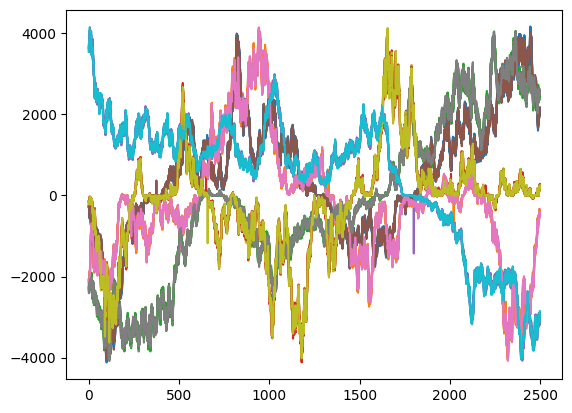

In [20]:
fig = plt.figure()
ax  = fig.add_subplot()

for key,df in noise_data.items():

    ax = df['Current'].plot(ax=ax)

plt.show()

In [21]:
def memory_cap(x, y):

    x_norm  = x - np.mean(x)
    y_norm  = y - np.mean(y)
    lags    = np.arange(0, len(test_x))
    
    np.roll(x, -lag)-np.mean(x)
    

In [43]:
ccorr_list = []

for key, df in noise_data.items():
    
    test_x  = df['E0'].values
    test_y  = df['Current'].values
    lags    = np.arange(0, len(test_x))
    x       = test_x - np.mean(test_x)
    y       = test_y - np.mean(test_y)
    ccorr   = [(np.correlate(test_x, np.roll(test_y, -lag)) / (np.linalg.norm(test_x) * np.linalg.norm(test_y)))[0] for lag in lags]
    
    ccorr_list.append(ccorr)

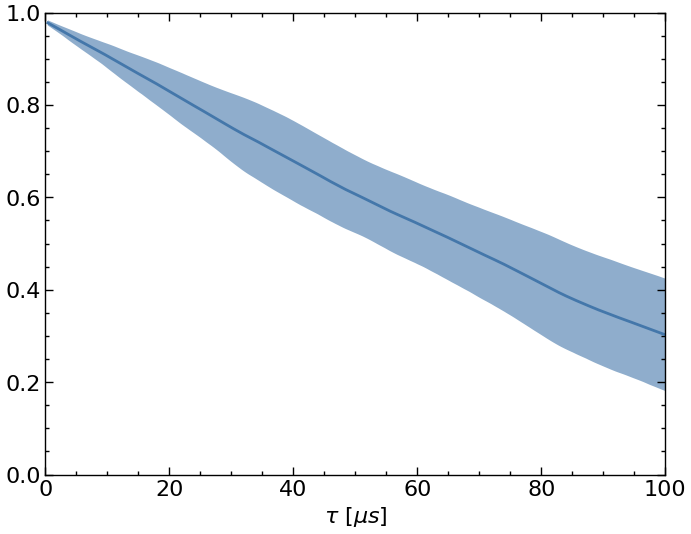

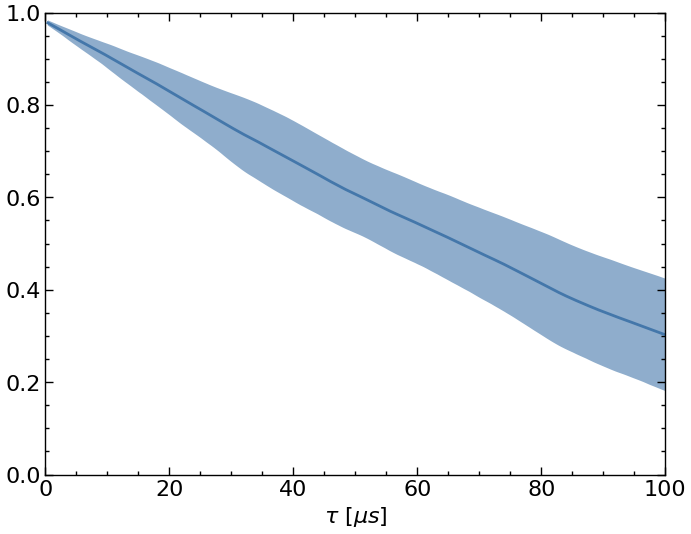

In [24]:
means   = np.mean(np.array(ccorr_list).T,axis=1)
stds    = np.std(np.array(ccorr_list).T,axis=1)

with plt.style.context(['science', 'bright','notebook']):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time_steps*10**6, means, '-')
    ax.fill_between(time_steps*10**6, means-stds, means+stds, alpha=0.6)
    # ax.plot(time_steps*10**6, np.mean(np.array(ccorr_list).T,axis=1))
    ax.set_xlabel("$\\tau$ [$\mu s$]")
    ax.set_xlim(0,100)
    ax.set_ylim(0,1)
    plt.show()

In [ ]:
with plt.style.context(['science', 'bright','notebook']):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(np.arange(0,len(test_x)), test_x)
    ax2 = ax.twinx()
    ax2.plot(np.arange(len(test_x),len(test_x)*2), test_y)

In [ ]:
# Sample time series data for x and y
x = np.array([1, 2, 3, 4, 5])
y = np.array([3, 4, 5, 6, 7])

# Calculate the cross-correlation using the normalized cross-correlation formula
cross_corr = [np.correlate(x, np.roll(y, -lag)) / (np.linalg.norm(x) * np.linalg.norm(y)) for lag in range(len(x))]

# Create the lag values
lags = range(len(x))

# Plot the standardized cross-correlation as a function of τ
plt.plot(lags, cross_corr)
plt.xlabel('Time Lag (τ)')
plt.ylabel('Standardized Cross-correlation')
plt.show()

In [ ]:
blue_color          = '#4477AA'
red_color           = '#EE6677'

with plt.style.context(["science","nature","bright"]):
    
    fig, ax1    = plt.subplots(dpi=200)
    ax2         = ax1.twinx()

    ax1.errorbar(x=time_steps[:-1]*1000 ,y=df['O'], yerr=df['sO'], c=blue_color)
    ax2.plot(time_steps[:-1]*1000, df['I']*1000, c=red_color)
    ax1.set_xlabel("Time [ms]")
    ax1.set_ylabel("Output [pA]")
    ax2.set_ylabel("Input [mV]")

    ax1.legend(['Output'], loc='lower left')
    ax2.legend(['Input'], loc='lower right')

    ax1.set_ylim(-1500,1500)
    ax2.set_ylim(-50,50)

plt.show()

In [ ]:
with plt.style.context(["science","nature","bright"]):
    
    fig, ax1    = plt.subplots(dpi=200)
    df          = dic[0.5]

    ax1.plot(df['O'], df['I']*1000)
    ax1.set_xlabel("Input [mV]")
    ax1.set_ylabel("Output [pA]")
    plt.show()

# States

In [ ]:
G   = nx.DiGraph()
G.add_nodes_from([i for i in range(49+8)])
G.add_edges_from([eval(i) for i in pd.read_csv(f"data/periodic/net_currents_Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv").columns])
pos             = get_pos(7)
node_color      = np.repeat(blue_color, 49+8)
node_color[0:8] = None
node_labels     = {i:'' for i in range(49+8)}
node_labels[0]  = '$I$'
node_labels[2]  = '$C$'
node_labels[4]  = '$C$'
node_labels[7]  = '$O$'
node_labels[1]  = '$C$'
node_labels[3]  = '$C$'
node_labels[5]  = '$C$'
node_labels[6]  = '$C$'

In [ ]:
states = pd.read_csv(f"data/periodic/mean_state_Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
states

In [ ]:
s_vals = states.abs()
s_vals = s_vals/np.max(s_vals.max())
s_logs = np.log(s_vals)
s_logs = s_logs - np.min(s_logs.min())
s_logs

In [ ]:
s_flat  = states.values.flatten()
s_flat  = (s_flat - np.min(s_flat))/(np.max(s_flat) - np.min(s_flat))
s_flat  = s_flat.reshape(-1,49)
s_flat

In [51]:
with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    ax  = fig.add_subplot()

    def update(row):
        
        ax.clear()

        sizes       = np.repeat(0,49+8)
        s_vals      = states.iloc[row].values
        sizes[8:]   = 500*np.abs(s_vals)

        node_colors = np.repeat(blue_color, 49+8)
        node_colors[8:][s_vals < 0] = red_color

        nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax, node_color=node_colors, arrows=False, labels=node_labels, font_size=8)
        ax.set_title(f'$t = {np.round((10**6)*time_steps[row],2)}$ $\mu s$')
        plt.axis('off')


    ani = animation.FuncAnimation(fig, update, frames=len(states), interval=200, repeat_delay=1000, repeat=True)
    ani.save("test.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.


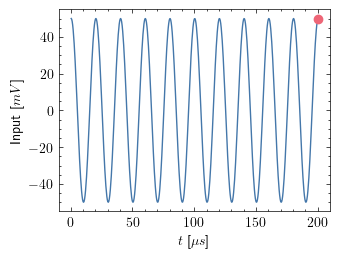

In [55]:
raw_data    = pd.read_csv(f"data/periodic/Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
in_vals     = 1000*raw_data['E0'].values
t_vals      = time_steps*10**6

with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    ax  = fig.add_subplot()

    def update(step):
        ax.clear()
        ax.plot(t_vals, in_vals)
        ax.plot(t_vals[step], in_vals[step], 'o')
        ax.set_xlabel('$t$ [$\mu s$]')
        ax.set_ylabel('Input [$mV$]')
        ax.set_xlim(0,200)
        ax.set_ylim(-50,50)
        
    ani = animation.FuncAnimation(fig, update, frames=len(states), interval=200, repeat_delay=1000, repeat=True)
    ani.save("test2.gif")

plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


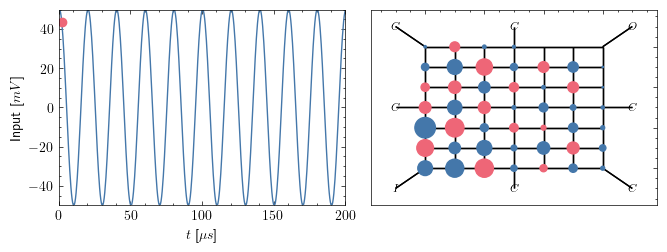

In [61]:
raw_data    = pd.read_csv(f"data/periodic/Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
in_vals     = 1000*raw_data['E0'].values
t_vals      = time_steps*10**6

with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    fig.set_figwidth(2*single_col*cmeter)
    # fig.set_figheight(single_col*cmeter)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    def update(row):

        ax1.clear()
        ax1.plot(t_vals, in_vals)
        ax1.plot(t_vals[row], in_vals[row], 'o')
        ax1.set_xlabel('$t$ [$\mu s$]')
        ax1.set_ylabel('Input [$mV$]')
        ax1.set_xlim(0,200)
        ax1.set_ylim(-50,50)

        ax2.clear()

        sizes       = np.repeat(0,49+8)
        s_vals      = states.iloc[row].values
        sizes[8:]   = 500*np.abs(s_vals)

        node_colors = np.repeat(blue_color, 49+8)
        node_colors[8:][s_vals < 0] = red_color

        nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax2, node_color=node_colors, arrows=False, labels=node_labels, font_size=8)
        ax.set_title(f'$t = {np.round((10**6)*time_steps[row],2)}$ $\mu s$')
        plt.tight_layout()
        # plt.axis('off')
        
    ani = animation.FuncAnimation(fig, update, frames=5, interval=200, repeat_delay=1000, repeat=True)
    ani.save("test.gif")

plt.show()